# 1. Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix ,precision_score, recall_score, roc_auc_score ,roc_curve, auc, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 2. Load Data

In [ ]:
drive.mount('/content/drive')

mon_features= pd.read_csv('/content/drive/MyDrive/Machine5/datasets/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/Machine5/datasets/mon_labels.csv')

# 3. Preprocess Data


In [3]:
# Feature selection based on features/mon_feature_information
# mon_features = mon_features[['total_num', 'total_sum_dir', 'inpkt_num', 'inpkt_avg_ordering',
#       'inpkt_std_ordering', 'outpkt_num', 'outpkt_avg_ordering',
#       'outpkt_std_ordering', 'inpkt_count_burst', 'outpkt_count_burst']]

In [4]:
X = mon_features
y = mon_labels

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Train/Test Shape:", X_train.shape, X_test.shape)

Data Train/Test Shape: (15200, 27) (3800, 27)


In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

# 4. Model selection

In [7]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [8]:
#하이퍼파라미터 튜닝(GridSearch)
param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'max_leaf_nodes': [50, 100, 200, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [9]:
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='accuracy',  
    cv=3,  
    random_state=42,  
    n_jobs=-1 
)
random_search.fit(X_train, y_train)

/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minseokim/miniconda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 20, 30, None],
                                        'max_leaf_nodes': [50, 100, 200, None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=42, scoring='accuracy')

In [10]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_closed_model = random_search.best_estimator_
y_pred = best_closed_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(95, 95))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': 20, 'class_weight': 'balanced'}
Best Score: 0.718223586543294

Accuracy: 0.7294736842105263

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66        42
           1       0.66      0.50      0.57        42
           2       0.74      0.91      0.82        35
           3       0.72      0.90      0.80        29
           4       0.69      0.92      0.79        39
           5       0.93      0.87      0.90        45
           6       0.72      0.86      0.78        44
           7       0.64      0.89      0.74        36
           8       0.71      0.74      0.72        34
           9       0.50      0.68      0.58        31
          10       0.86      0.66      0.75        47
          11       0.87      0.74      0.80        35
          12       0.80      0.86      0.83        42
   

In [11]:
# 확률 예측 (predict_proba 활용)
y_pred_proba_selected = best_closed_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_selected, pos_label=1)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_proba_selected, pos_label=1)
pr_auc = auc(recall_values, precision_values)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


ROC AUC: 0.9182
Precision-Recall AUC: 0.5469


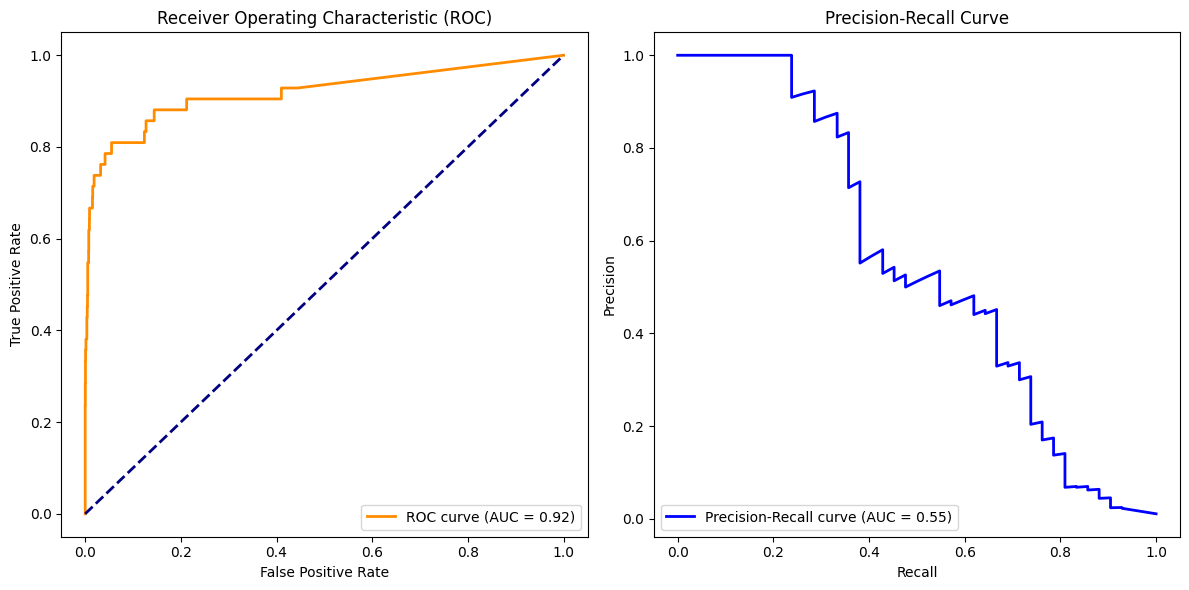

In [12]:
# Plot ROC and Precision-Recall Curves
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [18]:
%store best_closed_model

Stored 'best_closed_model' (RandomForestClassifier)


In [19]:
best_closed_model

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, random_state=42)

---

In [ ]:
unmon_features= pd.read_csv('/content/drive/MyDrive/Machine5/datasetsunmon_features.csv')
mon_features= pd.read_csv('/content/drive/MyDrive/Machine5/datasetse/mon_features.csv')
binary_labels = pd.read_csv('/content/drive/MyDrive/Machine5/datasets/binary_labels.csv')

In [43]:
combined_data = pd.concat([mon_features, unmon_features], axis=0, ignore_index= True)
combined_data.fillna(0, inplace=True)

X = combined_data
y = binary_labels

X

,total_num,total_sum_dir,total_avg,inpkt_num,inpkt_avg,inpkt_sum,inpkt_num_frac_total,inpkt_avg_ordering,inpkt_std_ordering,inpkt_num_frac_outpkt,...,outpkt_num_frac_inpkt,outpkt_sum_firstn,inpkt_std_burst,inpkt_max_burst,inpkt_avg_burst,inpkt_count_burst,outpkt_std_burst,outpkt_max_burst,outpkt_avg_burst,outpkt_count_burst
0,1421,-603648,4.315749,1300,4.292023,5579.63,0.914849,704.106154,398.486335,10.743802,...,0.093077,7.39,17.195458,66,16.666667,78,1.139584,8,1.551282,78
1,518,-183296,4.611815,438,4.673242,2046.88,0.845560,264.406393,150.591146,5.475000,...,0.182648,9.71,12.176200,50,9.319149,47,1.128262,5,1.702128,47
2,1358,-574464,5.488969,1240,5.459452,6769.72,0.913108,668.259677,381.878642,10.508475,...,0.095161,7.83,16.584084,50,16.315789,76,0.978650,6,1.552632,76
3,1446,-615424,5.995512,1324,5.948693,7876.07,0.915629,713.503021,406.205288,10.852459,...,0.092145,11.53,17.252464,70,16.550000,80,0.851102,5,1.525000,80
4,1406,-602112,4.698869,1291,4.663873,6021.06,0.918208,694.740511,395.028889,11.226087,...,0.089078,7.17,16.014144,60,16.341772,79,0.882996,5,1.455696,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28995,4593,-1928704,12.494690,4180,12.360713,51667.78,0.910081,2270.961722,1337.407077,10.121065,...,0.098804,17.30,16.349985,69,16.328125,256,1.185041,10,1.619608,255
28996,5110,-2158592,13.844609,4663,13.729719,64021.68,0.912524,2505.849024,1450.994832,10.431767,...,0.095861,42.56,18.897256,87,20.724444,225,2.415533,23,1.995536,224
28997,361,-124416,3.568144,302,3.251291,981.89,0.836565,180.175497,101.241755,5.118644,...,0.195364,17.90,12.087057,41,10.785714,28,1.838852,8,2.107143,28
28998,509,-162304,6.892377,413,6.689346,2762.70,0.811395,241.169492,138.848134,4.302083,...,0.232446,20.69,9.963438,42,7.375000,56,1.047348,5,1.714286,56


In [44]:
scaler = StandardScaler()
features_modified = scaler.fit_transform(X)

In [45]:
def update_labels(X, model):
    rows_to_predict = y['label'] == 1
    predictions = model.predict(X[rows_to_predict])
    y.loc[rows_to_predict, 'label'] = predictions
    return X

In [46]:
X = update_labels(X, best_closed_model)

In [ ]:
label = y

In [ ]:
label.to_csv(path_or_buf='/content/drive/MyDrive/Machine5/datasets'+'final_labels.csv', index=False, mode='w')

---

In [ ]:
mon_labels = pd.read_csv('/content/drive/MyDrive/Machine5/datasets/mon_labels.csv').values 
unmonlen = len(y) - len(mon_labels)
unmon_labels = -np.ones(unmonlen).reshape(-1, 1)
labels = np.concatenate([mon_labels, unmon_labels])

In [51]:
y_pred = y  
y_true = labels 

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=1, average='macro')
recall = recall_score(y_true, y_pred, pos_label=1, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

precision_values, recall_values, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
pr_auc = auc(recall_values, precision_values)

# Display results
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Model Precision: {precision:.4f}")
print(f"Model Recall: {recall:.4f}")
print(f"Model ROC AUC: {roc_auc:.4f}")
print(f"Model PR AUC: {pr_auc:.4f}")
print(f"Model Confusion Matrix:")
plt.figure(figsize=(95, 95))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Model Accuracy: 0.8136
Model Precision: 0.8657
Model Recall: 0.7885
Model ROC AUC: 0.3905
Model PR AUC: 0.0054
Model Confusion Matrix:


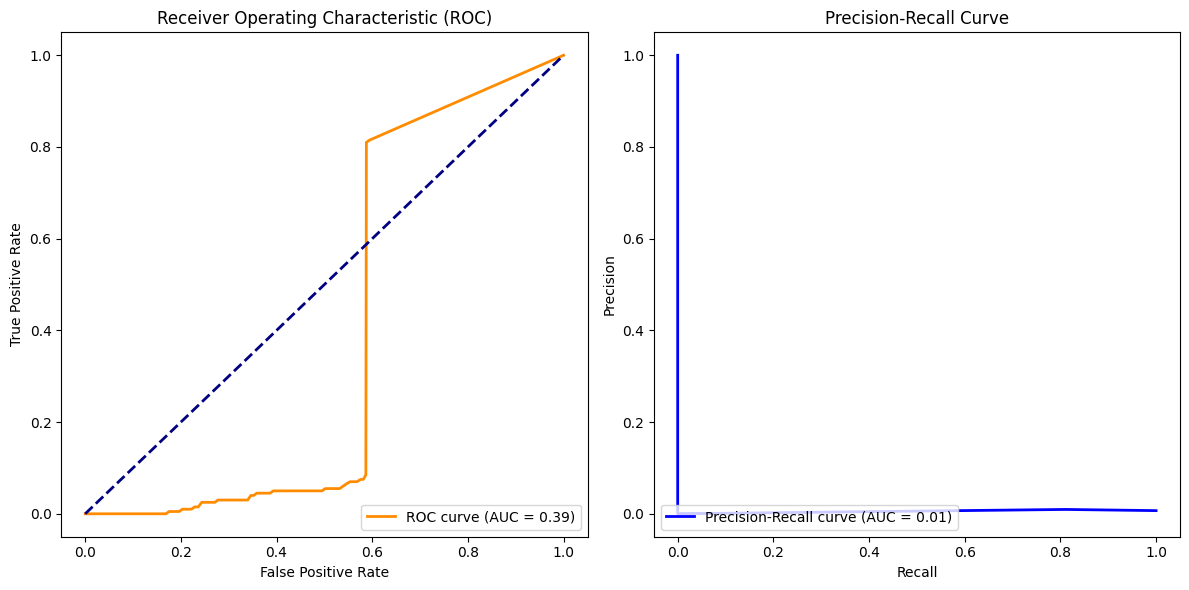

In [52]:
# Plot ROC and Precision-Recall Curves
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()